In [ ]:
import pandas as pd
import requests
import seaborn as sns

sns.set_theme(palette="deep")


In [ ]:
from io import BytesIO
from urllib.parse import urlencode

base_url = "anonymized"
public_key = "anonymized"

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()["href"]
response = requests.get(download_url)

path_to_dataset = "data"  # Choose any appropriate local path


parquet_file = BytesIO(response.content)
df = pd.read_parquet(parquet_file, engine="pyarrow")  # or engine='fastparquet'

# zipfile = ZipFile(BytesIO(response.content))
# zipfile.extractall(path=path_to_dataset)

In [3]:
mmlu_entropy_df = df
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,False,"[0.739037036895752, 1.6074764728546143, 0.2694...","[[{""token_idx"": 16, ""token_prob"": 0.0056026899...",350,To determine the most compelling criticism of ...,"{""min"": [-1.765625, -2.25, -1.0078125, -1.5546...","{""min"": [-2.0, -1.2890625, -0.97265625, -1.742...","{""min"": [0.08251953125, -0.859375, 0.36328125,..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.44923800230026245, 0.52848881483078, 0.0339...","[[{""token_idx"": 1, ""token_prob"": 1.20153881653...",298,To determine which of the given articles are n...,"{""min"": [-1.734375, -2.078125, -0.51953125, -1...","{""min"": [-1.9765625, -1.734375, -0.7421875, -1...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7827358245849609, 1.3739895820617676, 0.138...","[[{""token_idx"": 12, ""token_prob"": 1.3965139260...",364,"To determine the correct answer, let's analyze...","{""min"": [-1.7734375, -2.375, -0.314453125, -1....","{""min"": [-1.7734375, -1.6953125, -0.306640625,...","{""min"": [0.130859375, -0.953125, 0.306640625, ..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.5698917508125305, 1.2224339246749878, 0.058...","[[{""token_idx"": 16, ""token_prob"": 0.0010091802...",345,"To find the total cost of the rental, we need ...","{""min"": [-1.828125, -2.140625, -0.376953125, -...","{""min"": [-1.890625, -1.7265625, -0.72265625, -...","{""min"": [-0.0869140625, -1.0, 0.60546875, 0.87..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.7429015040397644, 1.2687288522720337, 0.218...","[[{""token_idx"": 16, ""token_prob"": 0.0020184428...",278,"To solve this problem, we need to follow these...","{""min"": [-1.8203125, -2.1875, -0.58984375, -0....","{""min"": [-2.0, -2.28125, -1.1328125, -2.0625, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1...."


In [4]:
mmlu_entropy_df.value_counts("phi3_ans_token_index", dropna=False)

phi3_ans_token_index
-1       669
 419      49
 370      48
 415      43
 378      42
        ... 
 919       1
 915       1
 913       1
 677       1
 1021      1
Length: 896, dtype: int64

In [5]:
# Filter out unanswered questions (phi3_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["phi3_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 11363 after filtering


In [ ]:
def entropy_counter(arr):
    sum = 0
    for i in arr:
        sum -= i["token_prob"] * np.log(i["token_prob"])
    return sum

In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np


def extract_cot_answer_from_row(tokenizer, row, column_every_token_info, column_ans_token_index):
    every_token_info = json.loads(row[column_every_token_info])
    answer_token_probs = every_token_info[row[column_ans_token_index]]

    max_prob_idx = np.argmax([item["token_prob"] for item in answer_token_probs])
    answer_token = answer_token_probs[max_prob_idx]["token_idx"]
    return tokenizer.decode(answer_token)


def extract_cot_answer_entropy_from_row(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    return answer_token_entropy


def visualize_entropy_all(df, x, hue, model_name=None):
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="dodge",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
    plt.legend(
        handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer", loc="upper right"
    )
    if model_name is not None:
        plt.title(model_name)
    # plt.savefig("entropy_phi3.pdf")

    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="fill",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Proportion")
    plt.legend(handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer")
    if model_name is not None:
        plt.title(model_name)


In [8]:
import ast

len(ast.literal_eval(mmlu_entropy_df_filtered.phi3_entropies.iloc[0]))

353

In [9]:
from transformers import AutoTokenizer

# from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "microsoft/Phi-4-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["phi3_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "phi3_every_token_info", "phi3_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["phi3_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-05-19 10:02:28.301429: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 10:02:29.855015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 10:02:36.110212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_10429/144845555

In [ ]:
[
    tokenizer.encode(".\n\n"),
    tokenizer.encode(".\n"),
    tokenizer.encode("\n"),
    tokenizer.encode("\n\n"),
    tokenizer.encode(":\n\n"),
    tokenizer.encode(":\n"),
    tokenizer.encode("]\n"),
    tokenizer.encode("]\n\n"),
    tokenizer.encode(";\n\n"),
    tokenizer.encode(";\n"),
    tokenizer.encode(";"),
    tokenizer.encode("..."),
    tokenizer.encode("**\n\n"),
    tokenizer.encode("**\n"),
    tokenizer.encode("*\n\n"),
    tokenizer.encode("*\n"),
]

[[364],
 [558],
 [198],
 [279],
 [1402],
 [734],
 [1592],
 [3144],
 [502],
 [307],
 [26],
 [1008],
 [91587],
 [1612],
 [26289],
 [6658]]

In [11]:
ast.literal_eval(mmlu_entropy_df_filtered.phi3_every_token_info.iloc[0])[-1]

[{'token_idx': 13, 'token_prob': 0.002468241611495614},
 {'token_idx': 350, 'token_prob': 1.46766988109448e-05},
 {'token_idx': 364, 'token_prob': 0.0006240691291168332},
 {'token_idx': 558, 'token_prob': 0.00012288650032132864},
 {'token_idx': 887, 'token_prob': 1.6630880054435693e-05},
 {'token_idx': 1202, 'token_prob': 3.989540346083231e-05},
 {'token_idx': 2499, 'token_prob': 6.577640306204557e-05},
 {'token_idx': 3692, 'token_prob': 1.0087137525260914e-05},
 {'token_idx': 4707, 'token_prob': 2.741968637565151e-05},
 {'token_idx': 7816, 'token_prob': 1.2952142242284026e-05},
 {'token_idx': 8476, 'token_prob': 1.0087137525260914e-05},
 {'token_idx': 15227, 'token_prob': 1.6630880054435693e-05},
 {'token_idx': 199999, 'token_prob': 0.00015778938541188836},
 {'token_idx': 200020, 'token_prob': 0.9957596659660339}]

In [12]:
tokenizer.decode(200020)

'<|end|>'

In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        maxi = 0
        maxii = 0
        for i in sublist:
            if i["token_prob"] > maxi:
                maxii = maxi
                maxi = i["token_prob"]
        prob_max.append(1 - (maxi - maxii))
    return np.mean(prob_max)
    # return


mmlu_entropy_df_filtered["phi3_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/tmp/ipykernel_10429/3222809347.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(np.max([item["token_prob"] for item in sublist]))

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["phi3_max_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)


def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(sublist[np.argmax([item["token_prob"] for item in sublist])]["token_idx"])

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["phi3_argmax_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/tmp/ipykernel_10429/198420212.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_max_prob"] = mmlu_entropy_df_filtered.apply(
/tmp/ipykernel_10429/198420212.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_argmax_prob"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.mean([ind for ind in entropies])


mmlu_entropy_df_filtered["phi3_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/tmp/ipykernel_10429/785479905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.max([ind for ind in entropies])


mmlu_entropy_df_filtered["phi3_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/tmp/ipykernel_10429/459748147.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    # return np.mean([ind for ind in entropies])
    return np.abs(np.max([ind for ind in entropies]) - answer_token_entropy)


mmlu_entropy_df_filtered["phi3_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/tmp/ipykernel_10429/3928390433.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # ev = json.loads(row[every])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    top1, top2 = sorted(entropies, reverse=True)[:2]

    return abs(top1 - top2)
    # why = np.argmax([ind['token_prob'] for ind in ast.literal_eval(row[every])[check]])

    # piv = ast.literal_eval(mmlu_entropy_df_filtered.phi3_every_token_info.iloc[ran])[check][why]['token_idx']


mmlu_entropy_df_filtered["phi3_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/tmp/ipykernel_10429/2287951263.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(


In [19]:
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import roc_auc_score


def normalize_score(column):
    return 1 - column / column.max()


@dataclass
class ROC_AUC:
    roc_auc: float
    gini: float


def calculate_roc_auc(y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    gini = abs(2 * roc_auc - 1)
    return ROC_AUC(roc_auc=roc_auc, gini=gini)


def calculate_accuracy(df, model_answer_correct_col):
    return df[model_answer_correct_col].sum() / len(df)


def calculate_roc_auc_by_category(df, model_name, category_col, model_answer_correct_col, score_col, threshold=10):
    results = []

    roc_auc = calculate_roc_auc(df[model_answer_correct_col], normalize_score(df[score_col]))

    results.append(
        {
            "category": "ALL",
            "roc_auc": roc_auc.roc_auc,
            "gini": roc_auc.gini,
            "num_samples": len(df),
            "accuracy": calculate_accuracy(df, model_answer_correct_col),
            "model": model_name,
            "metric": score_col,
        }
    )

    for category in df[category_col].unique():
        df_cat = df[df[category_col] == category]
        if len(df_cat) < threshold:
            continue

        roc_auc = calculate_roc_auc(df_cat[model_answer_correct_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": roc_auc.roc_auc,
                "gini": roc_auc.gini,
                "num_samples": len(df_cat),
                "accuracy": calculate_accuracy(df_cat, model_answer_correct_col),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)

In [ ]:
option_ids = [str(i + 1) for i in range(20)]
# 0 is a special exception for "do not know"
option_ids_w_fallback = option_ids + ["0"]


def validate_mmlu_answer(answer):
    return str(answer) in option_ids_w_fallback


def keep_only_valid_and_known_answers(df, column_name, option_ids=option_ids):
    return df[df[column_name].isin(option_ids)]

In [21]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
# from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "phi3_answer")

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

phi3_answer
1         1402
0         1371
2         1232
4         1211
3         1200
6          914
7          913
5          885
8          854
9          715
10         633
12           4
11           3
16           2
432          1
420          1
428          1
52           1
438          1
491          1
40           1
78           1
608          1
-            1
36           1
34           1
280          1
27           1
256          1
25           1
20           1
18           1
17           1
164          1
160          1
15           1
13           1
number       1
dtype: int64
phi3_answer
1     1402
2     1232
4     1211
3     1200
6      914
7      913
5      885
8      854
9      715
10     633
12       4
11       3
16       2
13       1
15       1
17       1
18       1
20       1
dtype: int64


In [22]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings,phi3_answer,phi3_answer_entropy,phi3_prob_diff_ent,phi3_max_prob,phi3_argmax_prob,phi3_answer_entropy_cot_mean,phi3_answer_entropy_cot_max,phi3_answer_entropy_marg,phi3_answer_entropy_top_diff
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,False,"[0.739037036895752, 1.6074764728546143, 0.2694...","[[{""token_idx"": 16, ""token_prob"": 0.0056026899...",350,To determine the most compelling criticism of ...,"{""min"": [-1.765625, -2.25, -1.0078125, -1.5546...","{""min"": [-2.0, -1.2890625, -0.97265625, -1.742...","{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,0.009762,0.240888,"[0.8315128684043884, 0.47677022218704224, 0.92...","[1385, 11433, 290, 1645, 44655, 42893, 328, 10...",0.639666,3.013290,3.003528,0.015738
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.44923800230026245, 0.52848881483078, 0.0339...","[[{""token_idx"": 1, ""token_prob"": 1.20153881653...",298,To determine which of the given articles are n...,"{""min"": [-1.734375, -2.078125, -0.51953125, -1...","{""min"": [-1.9765625, -1.734375, -0.7421875, -1...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1...",5,1.013274,0.290829,"[0.9237420558929443, 0.8562420606613159, 0.995...","[1385, 11433, 1118, 328, 290, 4335, 10604, 553...",0.747505,3.015365,2.002090,0.043623
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7827358245849609, 1.3739895820617676, 0.138...","[[{""token_idx"": 12, ""token_prob"": 1.3965139260...",364,"To determine the correct answer, let's analyze...","{""min"": [-1.7734375, -2.375, -0.314453125, -1....","{""min"": [-1.7734375, -1.6953125, -0.306640625,...","{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.050801,0.251949,"[0.8361507654190063, 0.5001430511474609, 0.970...","[1385, 11433, 290, 6145, 6052, 11, 35717, 3053...",0.610590,2.699257,2.648456,0.130351
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.7429015040397644, 1.2687288522720337, 0.218...","[[{""token_idx"": 16, ""token_prob"": 0.0020184428...",278,"To solve this problem, we need to follow these...","{""min"": [-1.8203125, -2.1875, -0.58984375, -0....","{""min"": [-2.0, -2.28125, -1.1328125, -2.0625, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1....",9,0.264199,0.129641,"[0.8142979145050049, 0.42949527502059937, 0.95...","[1385, 17722, 495, 4792, 11, 581, 1309, 316, 2...",0.301936,2.292861,2.028662,0.031713
5,theoremQA-Finance,I,"['0.0', '-0.75', '-2.5', '-3.0', '2.5', '-2.0'...",business,Suppose the demand curve for oPads is given by...,NaN,139,8,74,Economics & Finance MCQs,Finance Questions,False,"[0.30417385697364807, 1.1247189044952393, 0.00...","[[{""token_idx"": 16, ""token_prob"": 0.0004079260...",434,To determine the elasticity of the demand func...,"{""min"": [-1.8203125, -2.234375, -0.33984375, -...","{""min"": [-2.21875, -1.6875, -1.4921875, -1.726...","{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.044382,0.172662,"[0.9470300078392029, 0.49576884508132935, 0.99...","[1385, 11433, 290, 134809, 328, 290, 8492, 111...",0.383086,2.379871,2.335489,0.068242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

<h2>Sequence mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.622520,0.245041,9973,0.551990,Qwen-3b,phi3_answer_entropy_sequence_mean
1,law,0.495186,0.009629,1033,0.284608,Qwen-3b,phi3_answer_entropy_sequence_mean
2,business,0.683869,0.367737,636,0.652516,Qwen-3b,phi3_answer_entropy_sequence_mean
3,psychology,0.581501,0.163003,764,0.630890,Qwen-3b,phi3_answer_entropy_sequence_mean
4,chemistry,0.647047,0.294095,814,0.600737,Qwen-3b,phi3_answer_entropy_sequence_mean
5,biology,0.583009,0.166018,663,0.713424,Qwen-3b,phi3_answer_entropy_sequence_mean
6,history,0.546494,0.092988,358,0.391061,Qwen-3b,phi3_answer_entropy_sequence_mean
7,other,0.574090,0.148179,848,0.516509,Qwen-3b,phi3_answer_entropy_sequence_mean
8,physics,0.573902,0.147804,986,0.569980,Qwen-3b,phi3_answer_entropy_sequence_mean
9,computer science,0.556092,0.112185,327,0.577982,Qwen-3b,phi3_answer_entropy_sequence_mean


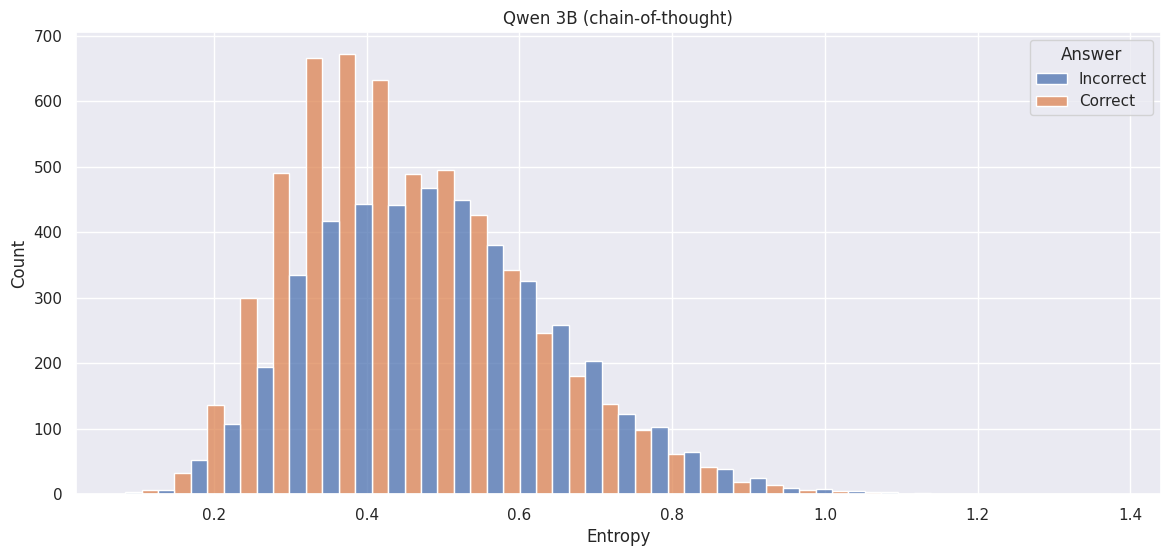

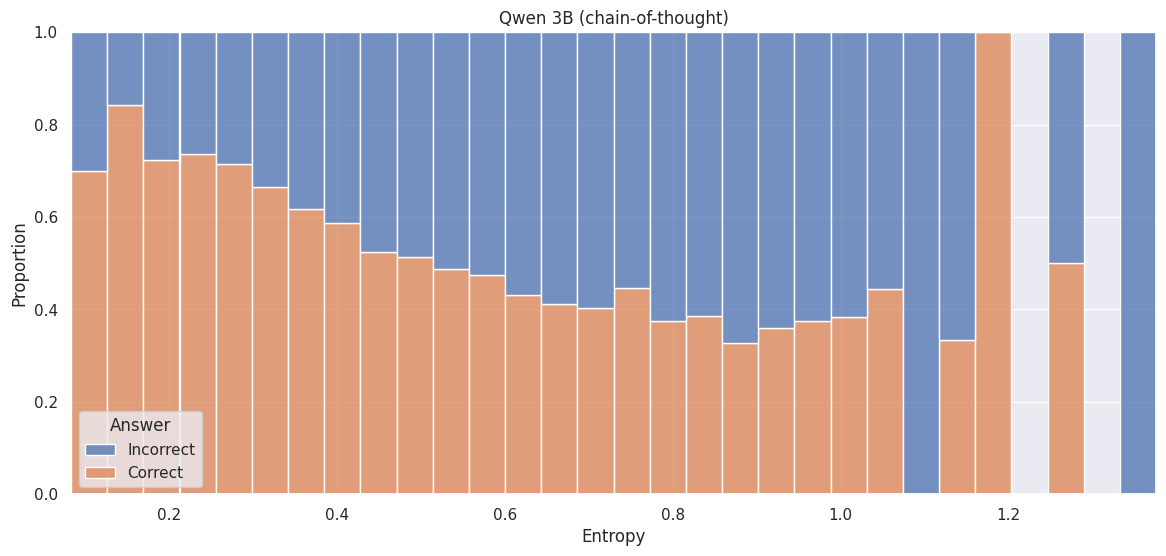

In [ ]:
splitters = [364, 558, 198, 279, 1402, 734, 1592, 3144, 502, 307, 26, 1008, 91587, 1612, 26289, 6658, 200020]
name = "phi3_answer_entropy_sequence_mean"


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    # print()
    # answer_token_entropy = entropies[row[column_ans_token_index]]

    # top1, top2 = sorted(entropies, reverse=True)[:2]
    entr = []
    seq_entr = []
    counter = 0
    # print(row[args])
    for sublist in row[args]:
        # prob_max = np.argmax([item['token_prob'] for item in sublist])
        entr.append(entropies[counter])
        # print(entr)
        if sublist in splitters:
            # print(entr)
            seq_entr.append(np.mean(entr))
            # print(np.mean(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)


visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence mean max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.621198,0.242395,9973,0.551990,Qwen-3b,phi3_answer_entropy_sequence_mean_max
1,law,0.560309,0.120617,1033,0.284608,Qwen-3b,phi3_answer_entropy_sequence_mean_max
2,business,0.684992,0.369983,636,0.652516,Qwen-3b,phi3_answer_entropy_sequence_mean_max
3,psychology,0.542509,0.085018,764,0.630890,Qwen-3b,phi3_answer_entropy_sequence_mean_max
4,chemistry,0.622319,0.244637,814,0.600737,Qwen-3b,phi3_answer_entropy_sequence_mean_max
5,biology,0.625325,0.250651,663,0.713424,Qwen-3b,phi3_answer_entropy_sequence_mean_max
6,history,0.589253,0.178506,358,0.391061,Qwen-3b,phi3_answer_entropy_sequence_mean_max
7,other,0.592304,0.184609,848,0.516509,Qwen-3b,phi3_answer_entropy_sequence_mean_max
8,physics,0.526753,0.053507,986,0.569980,Qwen-3b,phi3_answer_entropy_sequence_mean_max
9,computer science,0.602791,0.205582,327,0.577982,Qwen-3b,phi3_answer_entropy_sequence_mean_max


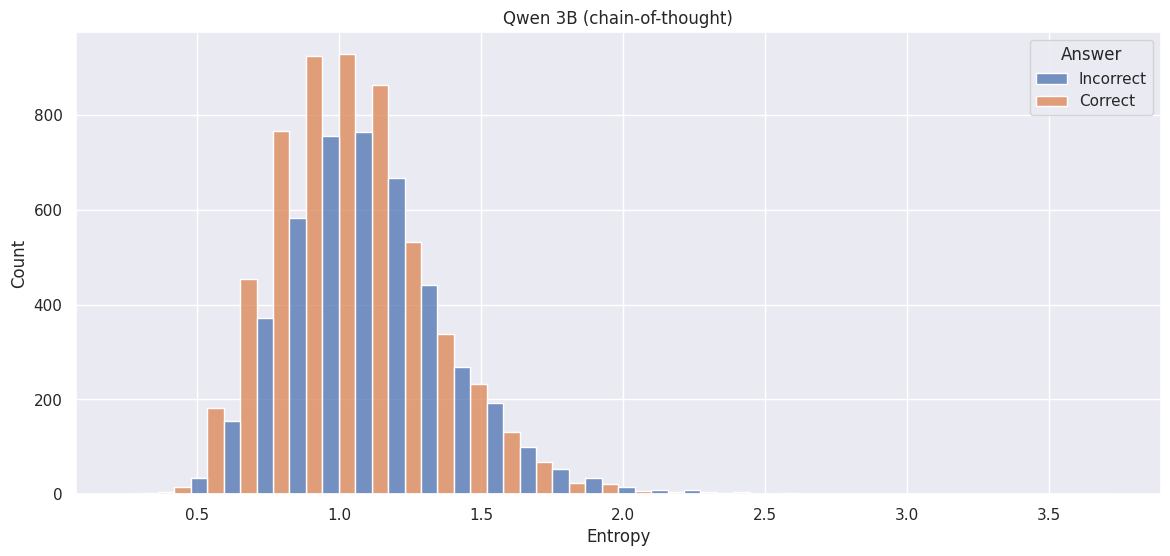

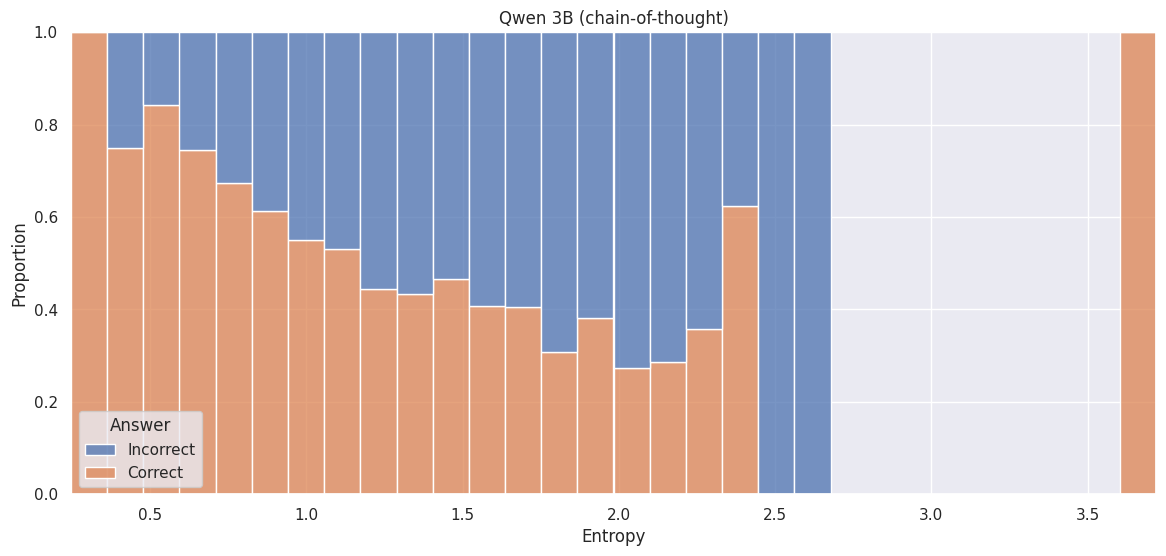

In [ ]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.mean(entr))

            entr = []
        counter += 1
    return np.max(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_mean_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)

name = "phi3_answer_entropy_sequence_mean_max"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence max mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.610967,0.221933,9973,0.551990,Qwen-3b,phi3_answer_entropy_sequence_max_mean
1,law,0.483661,0.032679,1033,0.284608,Qwen-3b,phi3_answer_entropy_sequence_max_mean
2,business,0.660917,0.321834,636,0.652516,Qwen-3b,phi3_answer_entropy_sequence_max_mean
3,psychology,0.565721,0.131441,764,0.630890,Qwen-3b,phi3_answer_entropy_sequence_max_mean
4,chemistry,0.626019,0.252037,814,0.600737,Qwen-3b,phi3_answer_entropy_sequence_max_mean
5,biology,0.577256,0.154512,663,0.713424,Qwen-3b,phi3_answer_entropy_sequence_max_mean
6,history,0.551442,0.102883,358,0.391061,Qwen-3b,phi3_answer_entropy_sequence_max_mean
7,other,0.569757,0.139514,848,0.516509,Qwen-3b,phi3_answer_entropy_sequence_max_mean
8,physics,0.590000,0.180001,986,0.569980,Qwen-3b,phi3_answer_entropy_sequence_max_mean
9,computer science,0.542136,0.084273,327,0.577982,Qwen-3b,phi3_answer_entropy_sequence_max_mean


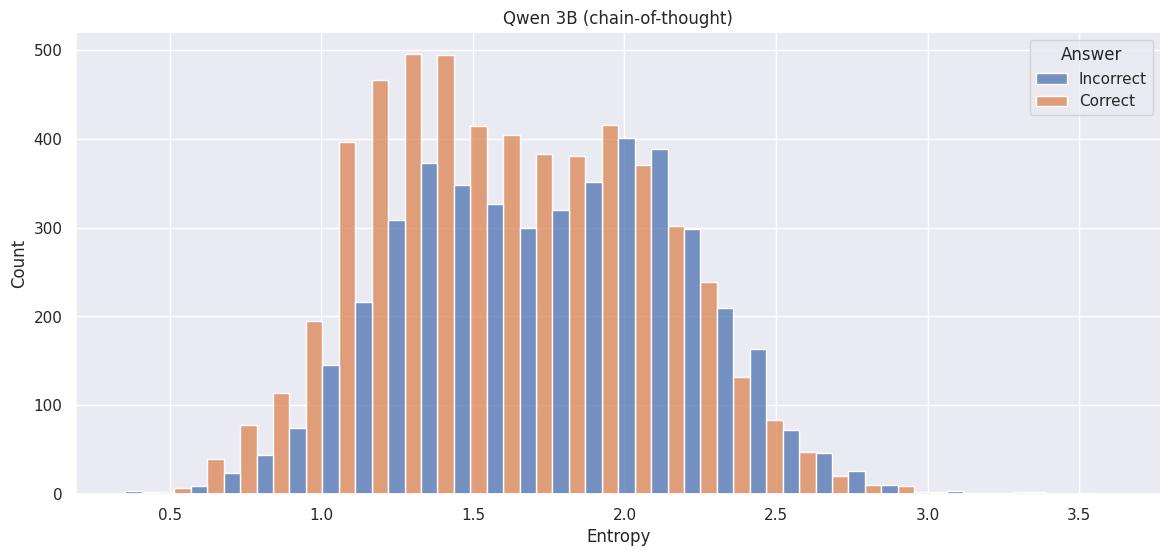

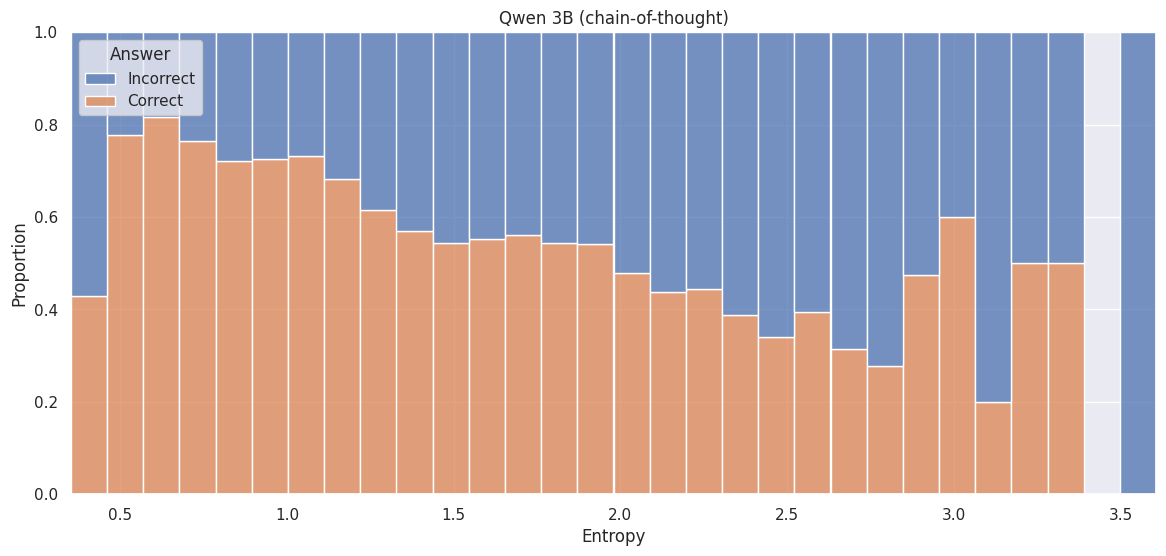

In [ ]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.max(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_max_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)

name = "phi3_answer_entropy_sequence_max_mean"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


In [26]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings,phi3_answer,phi3_answer_entropy,phi3_prob_diff_ent,phi3_max_prob,phi3_argmax_prob,phi3_answer_entropy_cot_mean,phi3_answer_entropy_cot_max,phi3_answer_entropy_marg,phi3_answer_entropy_top_diff,phi3_answer_entropy_sequence_mean,phi3_answer_entropy_sequence_mean_max,phi3_answer_entropy_sequence_max_mean
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,False,"[0.739037036895752, 1.6074764728546143, 0.2694...","[[{""token_idx"": 16, ""token_prob"": 0.0056026899...",350,To determine the most compelling criticism of ...,"{""min"": [-1.765625, -2.25, -1.0078125, -1.5546...","{""min"": [-2.0, -1.2890625, -0.97265625, -1.742...","{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,0.009762,0.240888,"[0.8315128684043884, 0.47677022218704224, 0.92...","[1385, 11433, 290, 1645, 44655, 42893, 328, 10...",0.639666,3.013290,3.003528,0.015738,0.476719,0.943046,1.697956
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.44923800230026245, 0.52848881483078, 0.0339...","[[{""token_idx"": 1, ""token_prob"": 1.20153881653...",298,To determine which of the given articles are n...,"{""min"": [-1.734375, -2.078125, -0.51953125, -1...","{""min"": [-1.9765625, -1.734375, -0.7421875, -1...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1...",5,1.013274,0.290829,"[0.9237420558929443, 0.8562420606613159, 0.995...","[1385, 11433, 1118, 328, 290, 4335, 10604, 553...",0.747505,3.015365,2.002090,0.043623,0.736304,1.098733,2.159111
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7827358245849609, 1.3739895820617676, 0.138...","[[{""token_idx"": 12, ""token_prob"": 1.3965139260...",364,"To determine the correct answer, let's analyze...","{""min"": [-1.7734375, -2.375, -0.314453125, -1....","{""min"": [-1.7734375, -1.6953125, -0.306640625,...","{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.050801,0.251949,"[0.8361507654190063, 0.5001430511474609, 0.970...","[1385, 11433, 290, 6145, 6052, 11, 35717, 3053...",0.610590,2.699257,2.648456,0.130351,0.569739,1.009380,1.823549
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.7429015040397644, 1.2687288522720337, 0.218...","[[{""token_idx"": 16, ""token_prob"": 0.0020184428...",278,"To solve this problem, we need to follow these...","{""min"": [-1.8203125, -2.1875, -0.58984375, -0....","{""min"": [-2.0, -2.28125, -1.1328125, -2.0625, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1....",9,0.264199,0.129641,"[0.8142979145050049, 0.42949527502059937, 0.95...","[1385, 17722, 495, 4792, 11, 581, 1309, 316, 2...",0.301936,2.292861,2.028662,0.031713,0.328589,0.671937,1.466674
5,theoremQA-Finance,I,"['0.0', '-0.75', '-2.5', '-3.0', '2.5', '-2.0'...",business,Suppose the demand curve for oPads is given by...,NaN,139,8,74,Economics & Finance MCQs,Finance Questions,False,"[0.30417385697364807, 1.1247189044952393, 0.00...","[[{""token_idx"": 16, ""token_prob"": 0.0004079260...",434,To determine the elasticity of the demand func...,"{""min"": [-1.8203125, -2.234375, -0.33984375, -...","{""min"": [-2.21875, -1.6875, -1.4921875, -1.726...","{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.044382,0.172662,"[0.9470300078392029, 0.4957688450

<h2>Entropy of Answer<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.583563,0.167127,9973,0.551990,Qwen-3b,phi3_answer_entropy
1,law,0.523658,0.047315,1033,0.284608,Qwen-3b,phi3_answer_entropy
2,business,0.559581,0.119163,636,0.652516,Qwen-3b,phi3_answer_entropy
3,psychology,0.645464,0.290927,764,0.630890,Qwen-3b,phi3_answer_entropy
4,chemistry,0.631474,0.262948,814,0.600737,Qwen-3b,phi3_answer_entropy
5,biology,0.666118,0.332235,663,0.713424,Qwen-3b,phi3_answer_entropy
6,history,0.512877,0.025754,358,0.391061,Qwen-3b,phi3_answer_entropy
7,other,0.583656,0.167313,848,0.516509,Qwen-3b,phi3_answer_entropy
8,physics,0.608188,0.216377,986,0.569980,Qwen-3b,phi3_answer_entropy
9,computer science,0.584234,0.168469,327,0.577982,Qwen-3b,phi3_answer_entropy


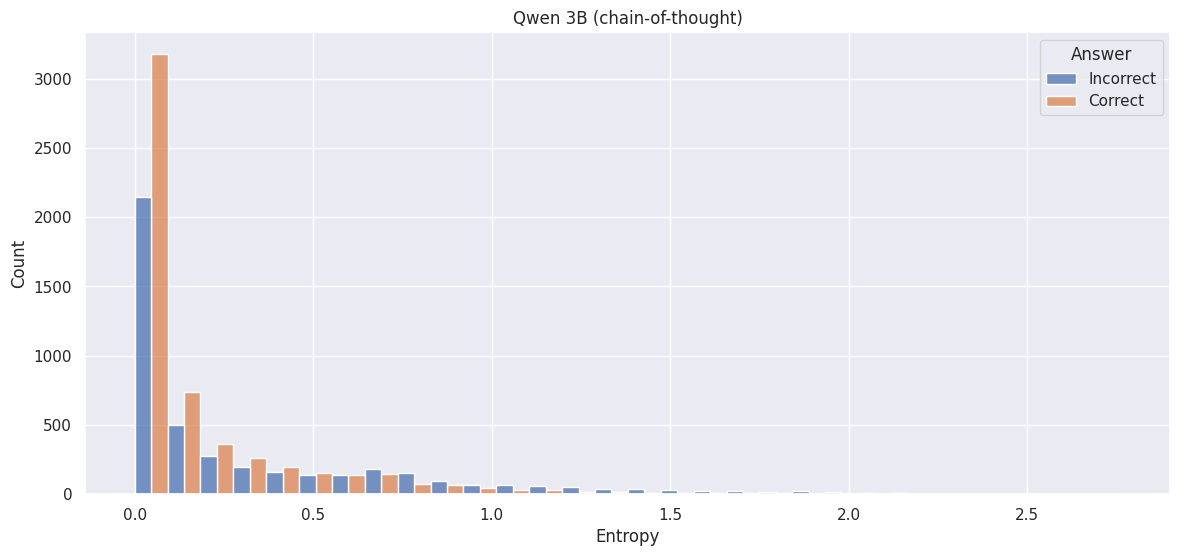

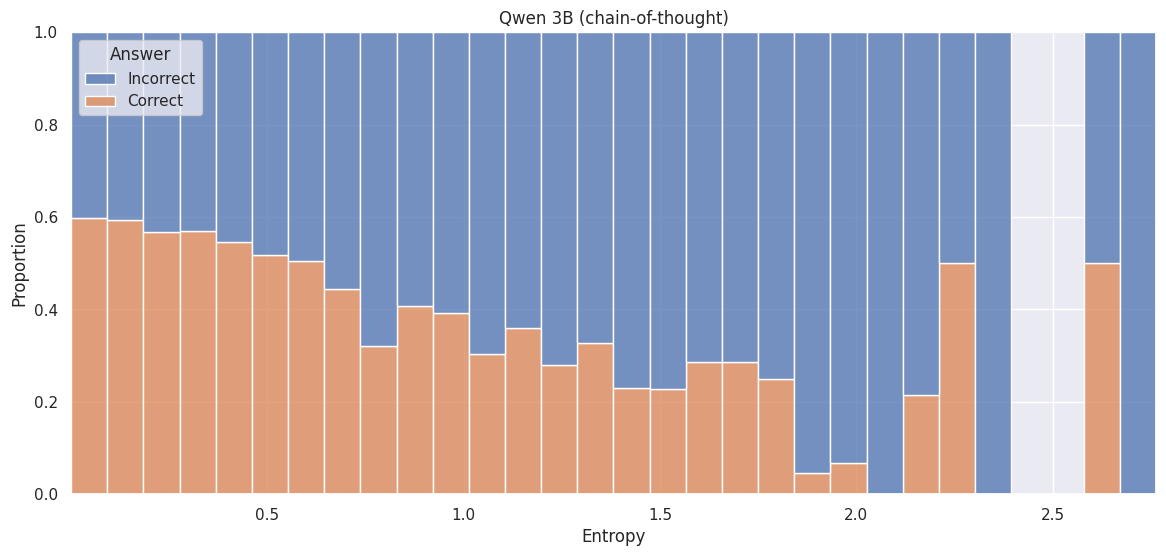

In [27]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy",
    model_name=model_title,
)
roc_auc_res

<h2>COT max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.648974,0.297948,9973,0.551990,Qwen-3b,phi3_answer_entropy_cot_max
1,law,0.516708,0.033415,1033,0.284608,Qwen-3b,phi3_answer_entropy_cot_max
2,business,0.712817,0.425634,636,0.652516,Qwen-3b,phi3_answer_entropy_cot_max
3,psychology,0.555671,0.111342,764,0.630890,Qwen-3b,phi3_answer_entropy_cot_max
4,chemistry,0.649482,0.298965,814,0.600737,Qwen-3b,phi3_answer_entropy_cot_max
5,biology,0.620830,0.241660,663,0.713424,Qwen-3b,phi3_answer_entropy_cot_max
6,history,0.608486,0.216972,358,0.391061,Qwen-3b,phi3_answer_entropy_cot_max
7,other,0.611015,0.222029,848,0.516509,Qwen-3b,phi3_answer_entropy_cot_max
8,physics,0.611961,0.223922,986,0.569980,Qwen-3b,phi3_answer_entropy_cot_max
9,computer science,0.613335,0.226670,327,0.577982,Qwen-3b,phi3_answer_entropy_cot_max


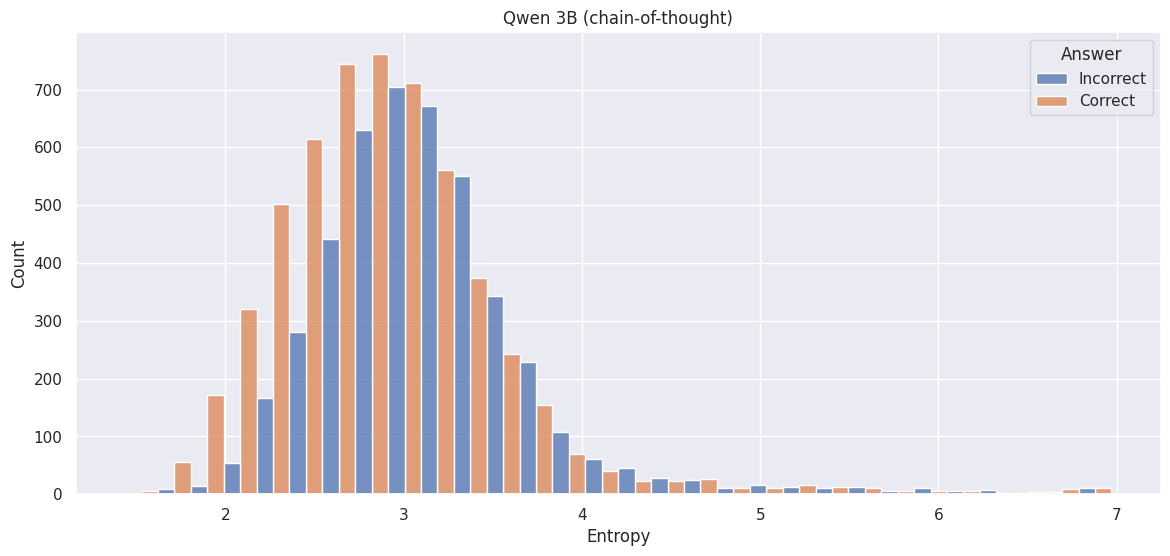

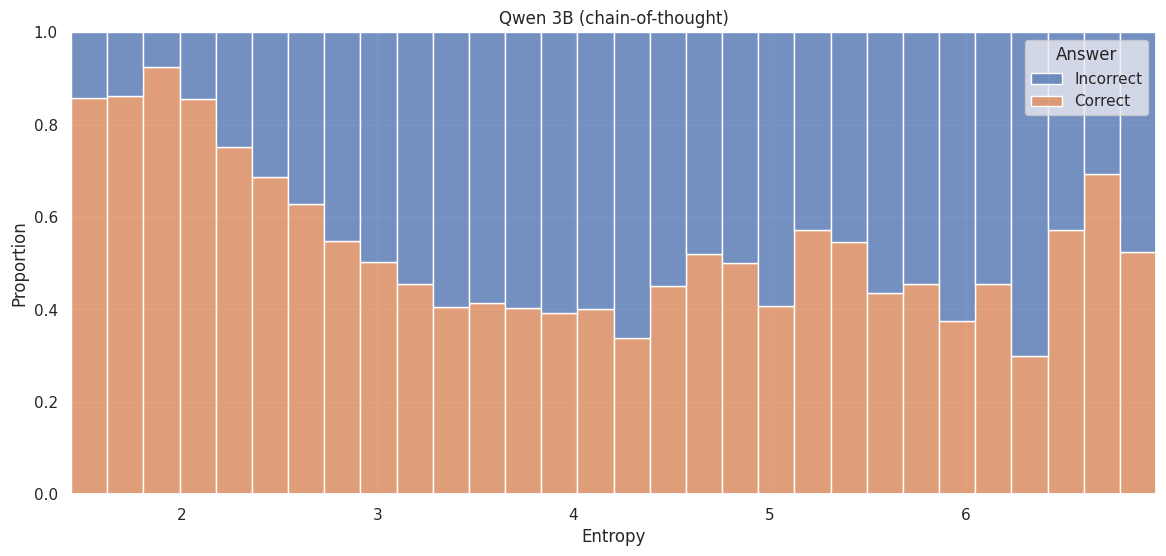

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy_cot_max", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_cot_max",
    model_name=model_title,
)
roc_auc_res


<h2>COT mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.627751,0.255503,9973,0.551990,Qwen-3b,phi3_answer_entropy_cot_mean
1,law,0.494159,0.011682,1033,0.284608,Qwen-3b,phi3_answer_entropy_cot_mean
2,business,0.696364,0.392727,636,0.652516,Qwen-3b,phi3_answer_entropy_cot_mean
3,psychology,0.602837,0.205674,764,0.630890,Qwen-3b,phi3_answer_entropy_cot_mean
4,chemistry,0.648627,0.297253,814,0.600737,Qwen-3b,phi3_answer_entropy_cot_mean
5,biology,0.583365,0.166730,663,0.713424,Qwen-3b,phi3_answer_entropy_cot_mean
6,history,0.559273,0.118545,358,0.391061,Qwen-3b,phi3_answer_entropy_cot_mean
7,other,0.580839,0.161677,848,0.516509,Qwen-3b,phi3_answer_entropy_cot_mean
8,physics,0.596895,0.193791,986,0.569980,Qwen-3b,phi3_answer_entropy_cot_mean
9,computer science,0.561728,0.123457,327,0.577982,Qwen-3b,phi3_answer_entropy_cot_mean


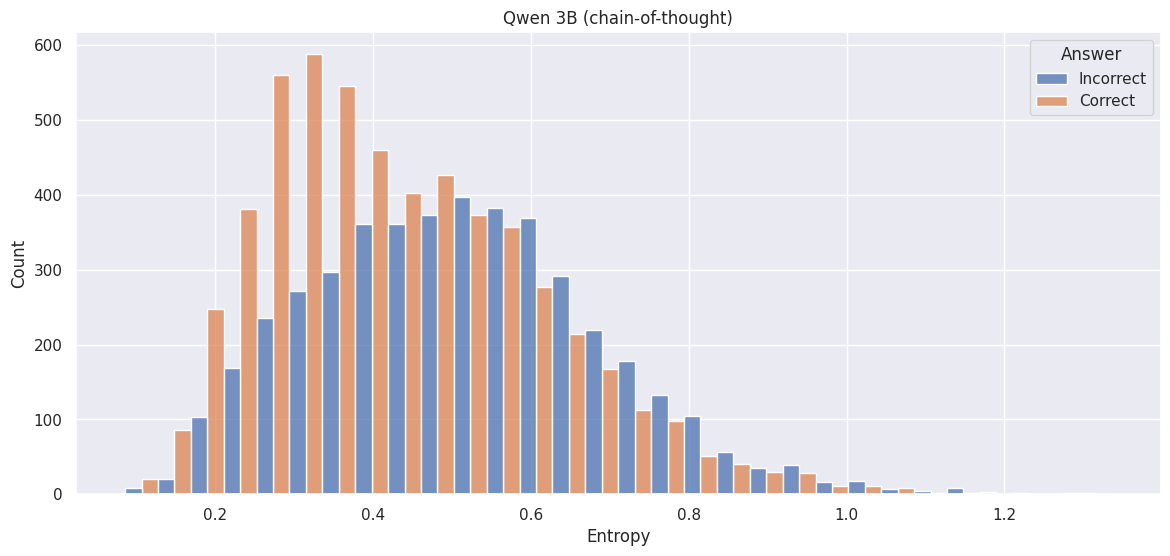

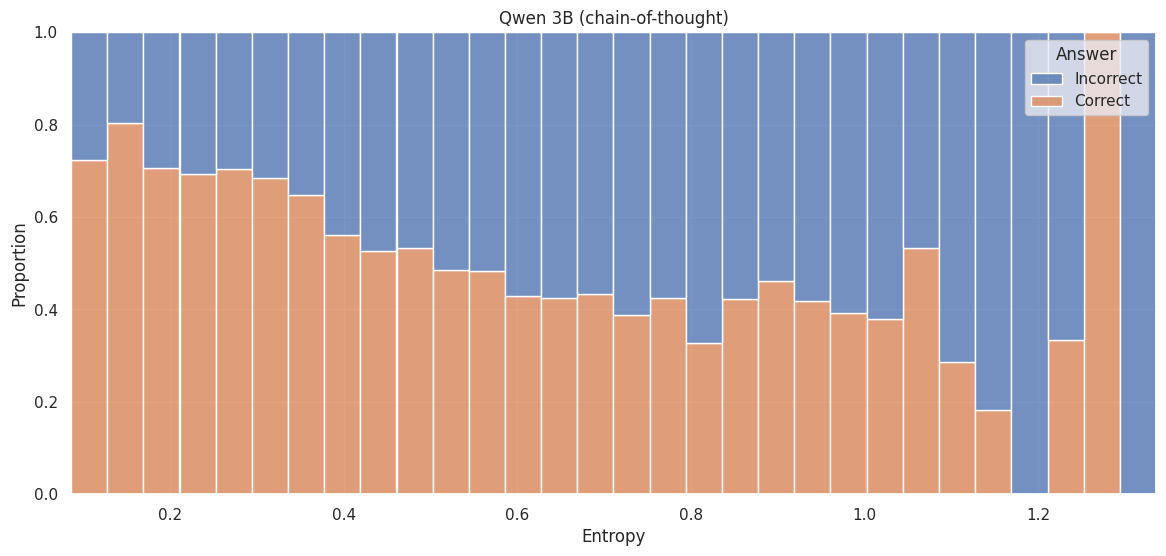

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy_cot_mean",
    "phi3_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_cot_mean",
    model_name=model_title,
)
roc_auc_res


<h2>Max COT entropy and answer entropy difference<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.574431,0.148861,9973,0.551990,Qwen-3b,phi3_answer_entropy_marg
1,law,0.486947,0.026106,1033,0.284608,Qwen-3b,phi3_answer_entropy_marg
2,business,0.616835,0.233670,636,0.652516,Qwen-3b,phi3_answer_entropy_marg
3,psychology,0.471874,0.056252,764,0.630890,Qwen-3b,phi3_answer_entropy_marg
4,chemistry,0.548907,0.097813,814,0.600737,Qwen-3b,phi3_answer_entropy_marg
5,biology,0.506265,0.012529,663,0.713424,Qwen-3b,phi3_answer_entropy_marg
6,history,0.580111,0.160223,358,0.391061,Qwen-3b,phi3_answer_entropy_marg
7,other,0.553169,0.106337,848,0.516509,Qwen-3b,phi3_answer_entropy_marg
8,physics,0.518612,0.037224,986,0.569980,Qwen-3b,phi3_answer_entropy_marg
9,computer science,0.522468,0.044935,327,0.577982,Qwen-3b,phi3_answer_entropy_marg


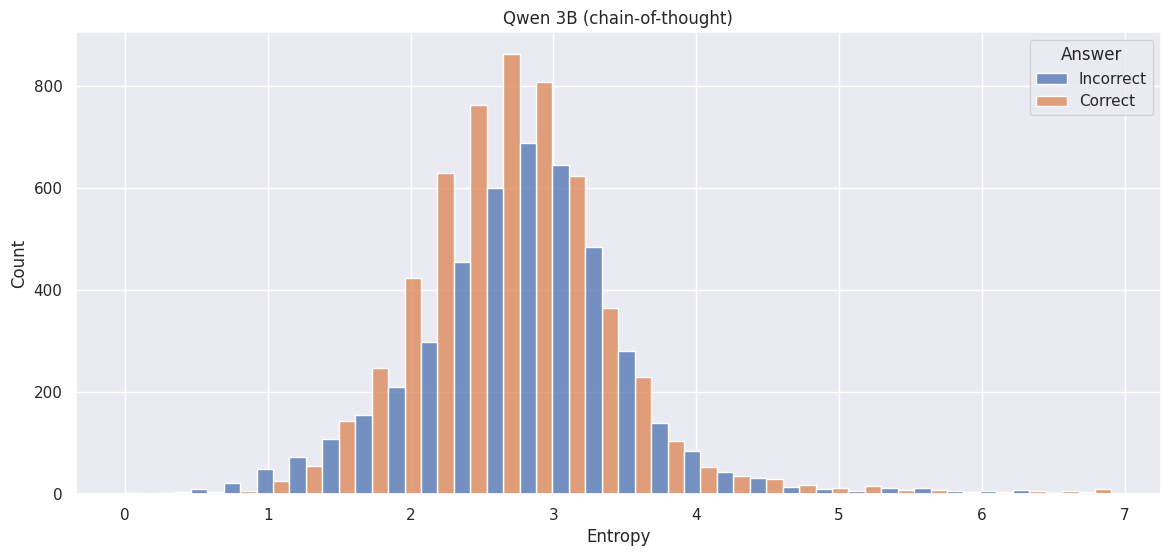

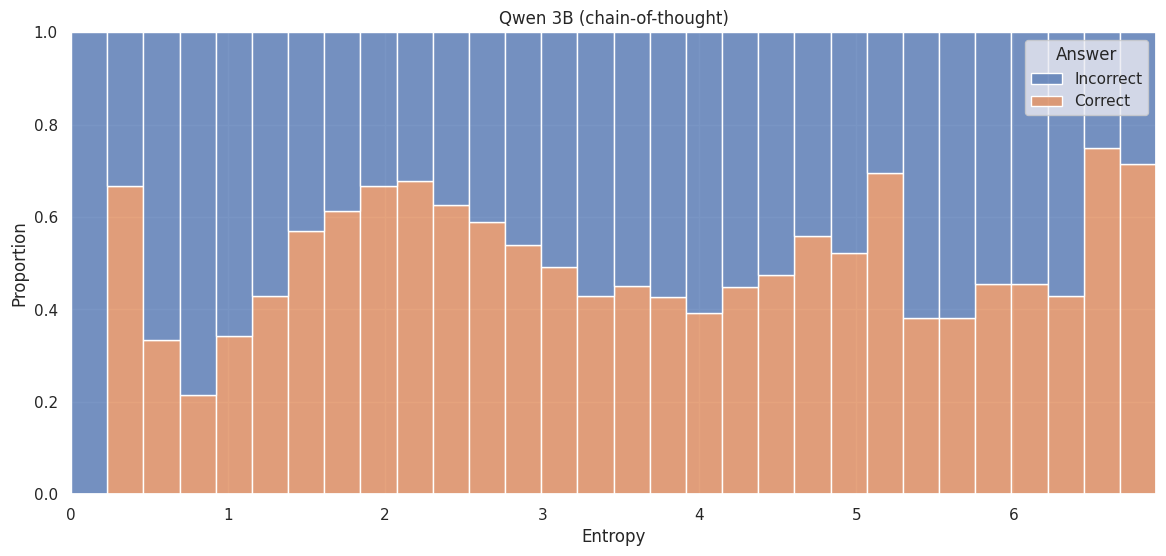

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy_marg", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_marg",
    model_name=model_title,
)
roc_auc_res

<h2>Mean of Marginal difference of 2 highest probs for each token<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.612500,0.225000,9973,0.551990,Qwen-3b,phi3_prob_diff_ent
1,law,0.478179,0.043642,1033,0.284608,Qwen-3b,phi3_prob_diff_ent
2,business,0.668146,0.336292,636,0.652516,Qwen-3b,phi3_prob_diff_ent
3,psychology,0.586982,0.173965,764,0.630890,Qwen-3b,phi3_prob_diff_ent
4,chemistry,0.627151,0.254302,814,0.600737,Qwen-3b,phi3_prob_diff_ent
5,biology,0.567420,0.134839,663,0.713424,Qwen-3b,phi3_prob_diff_ent
6,history,0.553113,0.106225,358,0.391061,Qwen-3b,phi3_prob_diff_ent
7,other,0.567301,0.134603,848,0.516509,Qwen-3b,phi3_prob_diff_ent
8,physics,0.582455,0.164910,986,0.569980,Qwen-3b,phi3_prob_diff_ent
9,computer science,0.547887,0.095775,327,0.577982,Qwen-3b,phi3_prob_diff_ent


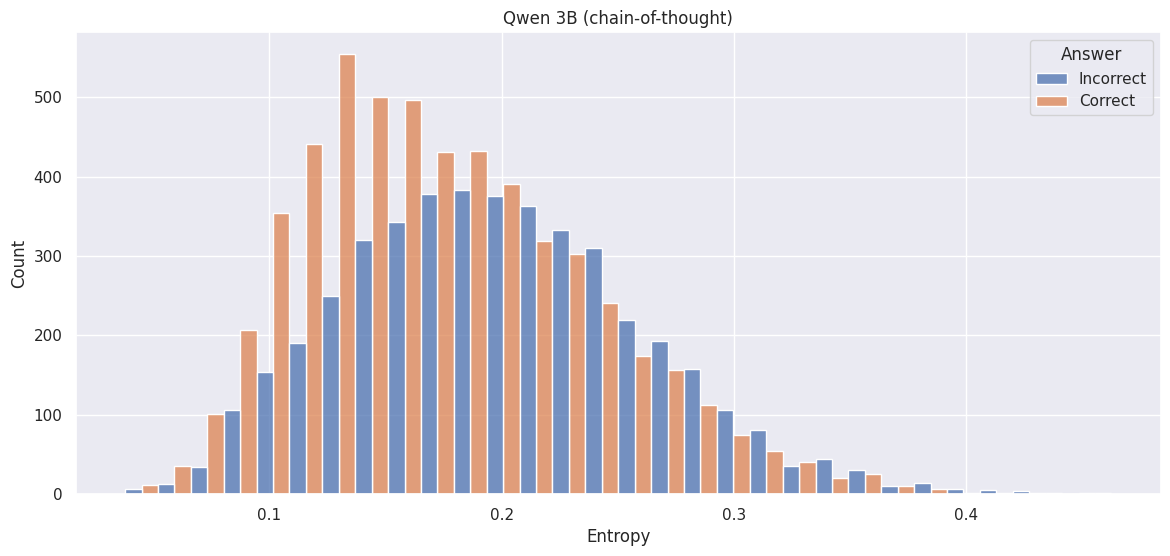

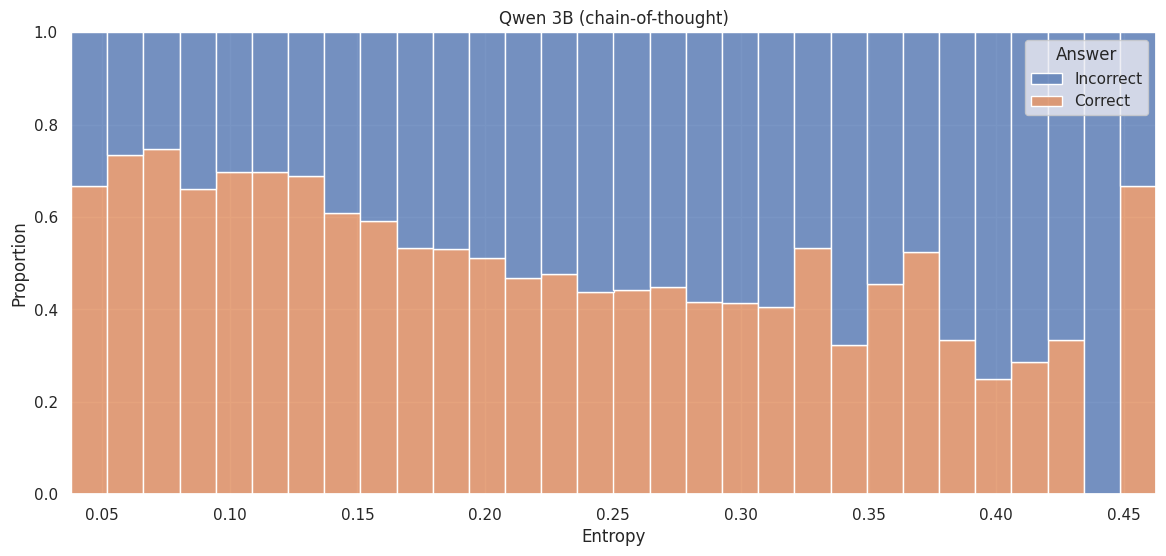

In [31]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_prob_diff_ent", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_prob_diff_ent",
    model_name=model_title,
)
roc_auc_res


<h2>Answer Entropy and Max COT mixed<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.615898,0.231795,9973,0.551990,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
1,law,0.524523,0.049046,1033,0.284608,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
2,business,0.599019,0.198037,636,0.652516,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
3,psychology,0.653453,0.306907,764,0.630890,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
4,chemistry,0.648771,0.297543,814,0.600737,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
5,biology,0.690853,0.381707,663,0.713424,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
6,history,0.562942,0.125885,358,0.391061,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
7,other,0.594977,0.189954,848,0.516509,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
8,physics,0.618151,0.236302,986,0.569980,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
9,computer science,0.608542,0.217085,327,0.577982,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix


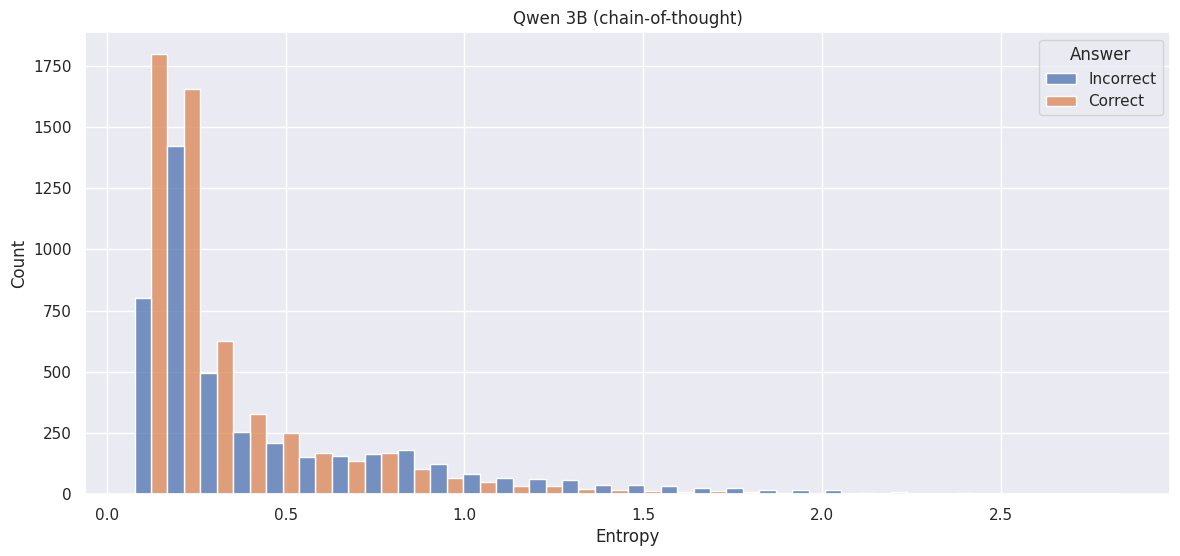

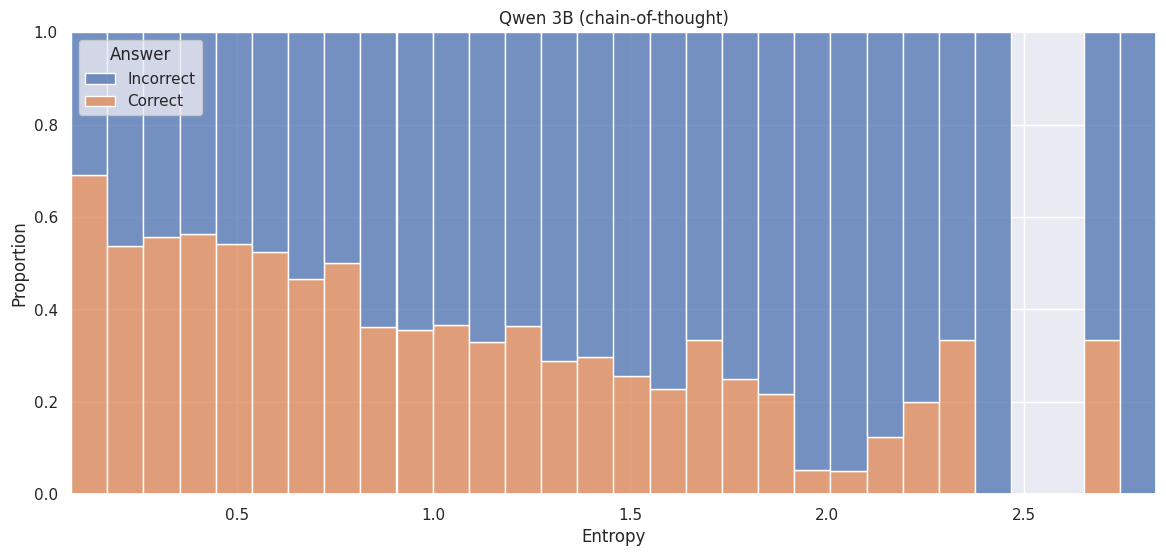

In [ ]:
name = "phi3_answer_entropy_max_ans_entropy_mix"


def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    answer_token_entropy = entropies[row[column_ans_token_index]]
    return 0.05 * np.max([ind for ind in entropies]) + 0.95 * answer_token_entropy


mmlu_entropy_df_filtered[name] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Diff of 2 highest entropies<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.505709,0.011418,9973,0.551990,Qwen-3b,phi3_answer_entropy_top_diff
1,law,0.488378,0.023243,1033,0.284608,Qwen-3b,phi3_answer_entropy_top_diff
2,business,0.514932,0.029864,636,0.652516,Qwen-3b,phi3_answer_entropy_top_diff
3,psychology,0.511124,0.022248,764,0.630890,Qwen-3b,phi3_answer_entropy_top_diff
4,chemistry,0.534743,0.069486,814,0.600737,Qwen-3b,phi3_answer_entropy_top_diff
5,biology,0.494169,0.011661,663,0.713424,Qwen-3b,phi3_answer_entropy_top_diff
6,history,0.553539,0.107077,358,0.391061,Qwen-3b,phi3_answer_entropy_top_diff
7,other,0.493574,0.012852,848,0.516509,Qwen-3b,phi3_answer_entropy_top_diff
8,physics,0.496487,0.007025,986,0.569980,Qwen-3b,phi3_answer_entropy_top_diff
9,computer science,0.519170,0.038341,327,0.577982,Qwen-3b,phi3_answer_entropy_top_diff


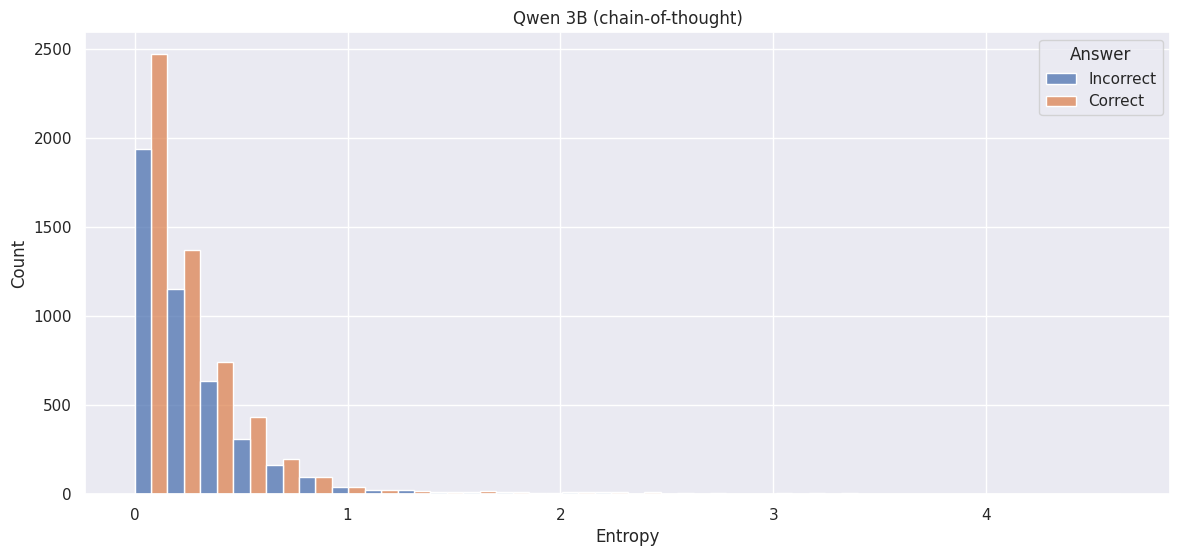

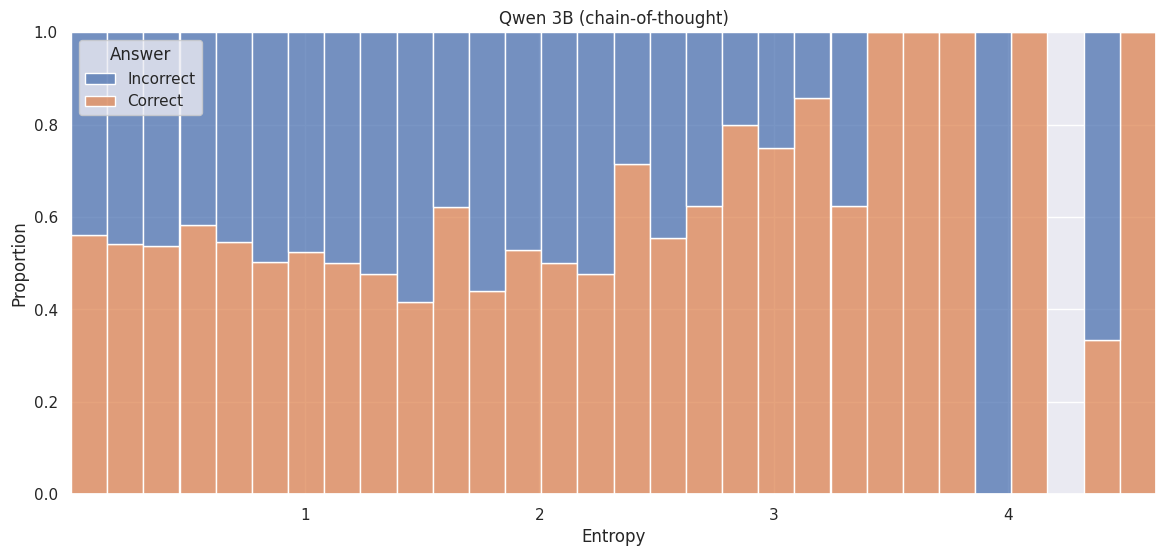

In [ ]:
# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy_top_diff",
    "phi3_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_top_diff",
    model_name=model_title,
)
roc_auc_res
